#**Transport Forecaster**



### **Add Project Folder to own Drive**
___________________________________________________


**IMPORTANT STEP** :

The nature of the code is to work on folders available in our own drives. This means that Shared Folders will be not be available, but we can work around this by adding a shortcut of the shared folder we are using. To do this, simply:

1. Go to https://drive.google.com/

2. On the left panel, click on *Shared with Me*

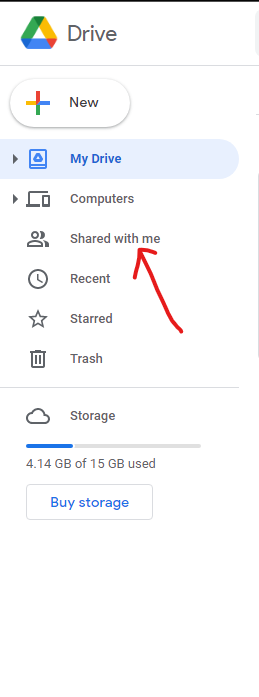

3. Find the shared folder. Let's say for example, in this case, it's this folder named *ARIMA*. Right click on it, and choose 'Add shortcut to drive'.


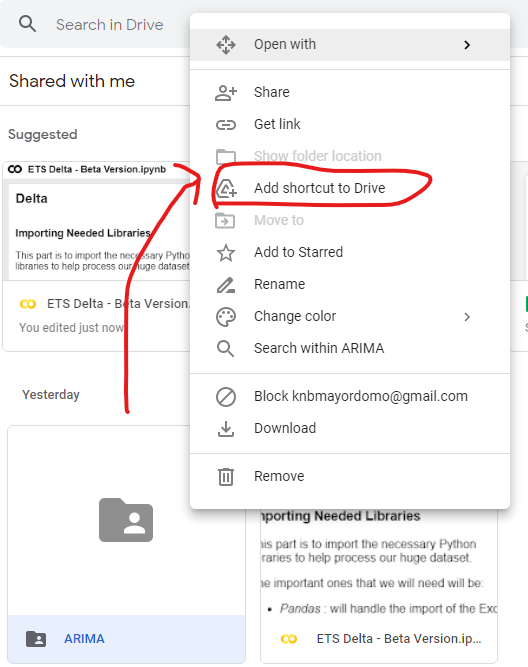

4. A small box should appear. Make sure *My Drive* is selected (1), then go ahead and click *ADD SHORTCUT* (2)

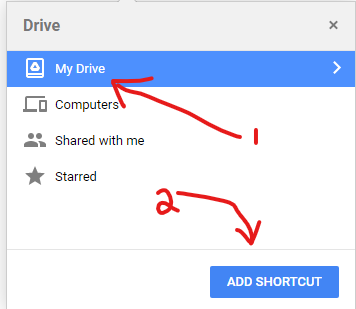

This should enable us to use the script, since we have a way of accessing the shared folder in our own Google Drives.

### **Importing Needed Libraries**
______________


This part is to import the necessary Python libraries to help process our huge dataset.

The important ones that we will need will be:
- *Pandas* : will handle the import of the Excel files and exporting them to CSV files. This will also be the main engine in performing aggregation and analysis tasks in our dataset;

- *Numpy* : to help us perform array operations, supporting Pandas;

- *Matplotlib, Seaborn* : for data visualization;

- *Drive from Google Colab* : since we will be working from a Google Drive storage base;

- *Statsmodels and PMDArima* : for performing forecasting using ARIMA for time series.

- *OS* : to navigate through folders.

(Recommended to click the play button twice to be sure packages are imported)

The resources used in this code are all open-sourced, meaning they are free to use and are constantly under development by the community.

In [ ]:
#@title {display-mode: "form"}
#@markdown <--- *Click to run the libraries.*

#import necessary libraries
!pip install openpyxl==3.0.9
!pip install statsmodels==0.11.0
!pip install pmdarima

#main tool to use to work on data frames
import pandas as pd
import numpy as np
#to loop through the directory
import os
#mounting google drive into the code
from datetime import datetime
from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pmdarima as pm

from google.colab import data_table
data_table.enable_dataframe_formatter()

dir_path= 'directory/path'

drive.mount('/content/drive/')
os.chdir(dir_path)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 242 kB 20.2 MB/s 
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.10
    Uninstalling openpyxl-3.0.10:
      Successfully uninstalled openpyxl-3.0.10
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.7 MB 6.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 6.8 MB/s 
Mounted at /content/drive/


### **Staging and Preprocessing**
_____________________


Data will be pulled at this stage from running file.

Here's a basic rundown of what it does at this stage:
1. Check for a folder named *Delta CSVs* in the current folder at which the code is located;
2. If the folder is found, look for the file named 'delta_complete.csv' and fetch its contents;
3. If not, create a new dataframe and scan the current folder for all of the files related to the project;
4. Save the contents into a dataframe. This will serve as the raw data.

Preprocessing converts the pulled data to a more manageable, "machine manipulable" form.

In [ ]:
#@title {display-mode: "form"}
#@markdown <--- *Click to begin staging  and preprocessing data.*
try :
  all = pd.read_csv('Delta CSVs/delta_complete.csv')
  indexer = len(all)
  uploaded_lines = all['line'].unique()
except FileNotFoundError:
  uploaded_lines = []
  indexer = 0

working_df = pd.DataFrame(columns=['date', 'dayofweek', 'line', 'route', 'time', 'actual supply', 'waiting pax', 'pax served'])
folders = ['001 Provincial', '002 City']

for folder in folders :
  filepath = '../PTX. OPS. TN. Supply and Demand. 2022 01 22/' + folder + "/"

  list_of_files = [filename for filename in sorted(os.listdir(filepath)) if filename.endswith('xlsx')]

  for excelfile in list_of_files :
    #if the filename is an excel file, then we will work on it
    if (excelfile.endswith('xlsx')) and (excelfile not in uploaded_lines):
      #in an excel file, we expect several sheets. we save that list here at sheetnames, take the count of that into number_of_sheetnames. this is an important variable
      sheetnames = pd.ExcelFile(filepath + excelfile).sheet_names
      number_of_sheets = len(sheetnames)
      for sheetname in sheetnames :
        try :
          #we save into a staging dataframe. what that means is that we keep it for the mean time in this dataframe and preprocess it.
          working_df = pd.DataFrame(columns=['date', 'dayofweek', 'line', 'route', 'time', 'actual supply', 'waiting pax', 'pax served'])
          print(f"at {excelfile} (file {sorted(list_of_files).index(excelfile) +1} of {len(list_of_files)}), sheet number {sheetnames.index(sheetname)+1} of {len(sheetnames)}")
          staging_df = pd.read_excel(filepath + excelfile, sheet_name=sheetname)

          change_col_type = []

          for col in staging_df.columns :
            if isinstance(col, datetime) :
              change_col_type.append(col.strftime("%m/%d/%Y"))
            else :
              change_col_type.append(col)

          staging_df.columns = change_col_type

          lb = staging_df[staging_df['TIME'] == 'TOTAL'].index[0]
          ub = len(staging_df['TIME'])

          staging_df.drop(labels=range(lb, ub), inplace=True)

          for column in staging_df.columns :
            if 'Unnamed' not in str(column) and 'TIME' not in str(column) :
              for idx, row in staging_df[2:].iterrows() :
                working_df.loc[indexer, "date"] = column
                working_df.loc[indexer, "dayofweek"] = staging_df.loc[0, column]
                working_df.loc[indexer, "time" ] = row['TIME'][:5]
                working_df.loc[indexer, "line" ] = excelfile
                working_df.loc[indexer, "route" ] = sheetname
                working_df.loc[indexer, "actual supply" ] = staging_df.loc[idx, column]
                working_df.loc[indexer, "waiting pax" ] = staging_df.iloc[idx, staging_df.columns.get_loc(column)+1]
                working_df.loc[indexer, "pax served" ] = staging_df.iloc[idx, staging_df.columns.get_loc(column)+2]
                indexer += 1
            working_df.to_csv('Delta CSVs/UNPACKED_ALL_DATA_run_f' + str(sorted(list_of_files).index(excelfile)) + 's' + str(sheetnames.index(sheetname)) + '.csv')
          print(" ", end="\r")
        except :
          print("Invalid Sheet!")

combine = os.listdir('Delta CSVs/')
all_files = pd.concat([pd.read_csv('Delta CSVs/'+csv, index_col = 0) for csv in combine])
all_files.to_csv('Delta CSVs/delta_complete.csv')

for i in combine :
  if not i.startswith('delta_') :
    os.remove('Delta CSVs/' + i)

def MapRoute(route) :
  map_routes = {
      'Alabang PUB' : 'ALABANG BUS',
      'ALABANG MODERN JEEP (ATSC)' : 'SOUTHMALL MODERN JEEP (ATSC)',
      'SOUTHMALL' : 'SOUTHMALL MODERN JEEP (ATSC)',
      'Alabang (ATSC)' : 'SOUTHMALL MODERN JEEP (ATSC)',
      'BGC Bus' : 'BGC',
      'BGC BUS' : 'BGC',
      'Route 13 BGC' : 'BGC',
      'BUENDIA' : 'BUENDIA MODERN JEEP (BEEP)' ,
      'BUENDIA (BEEP)' : 'BUENDIA MODERN JEEP (BEEP)',
      'BUENDIA - BEEP (MJ)' : 'BUENDIA MODERN JEEP (BEEP)',
      'Buendia (Beep)' : 'BUENDIA MODERN JEEP (BEEP)',
      'DASMARINAS - KAPIT-BISIG (MJ)' : 'DASMA MODERN JEEP (KAPIT-BISIG)',
      'Dasmarinas (Modern Jeep)' : 'DASMA MODERN JEEP (KAPIT-BISIG)',
      'EDSA Busway' : 'EDSA BUSWAY',
      'LAWTON - DYIPKO (MJ)' : 'LAWTON MODERN JEEP (DYIPKO)',
      'LAWTON VIA ROXAS' : 'LAWTON MODERN JEEP (DYIPKO)',
      'Lawton (Cher)' : 'LAWTON BUS (CHER)' ,
      'Lawton via Mabini' : 'LAWTON VIA MABINI',
      'MIA' : 'MIA-NAIA-BALTAO (MODERN JEP)',
      'MIA (SDTSC)' : 'MIA-NAIA-BALTAO (MODERN JEP)',
      'MIA MODERN JEEP (SDTSC)' : 'MIA-NAIA-BALTAO (MODERN JEP)',
      'NICHOLS' : 'NICHOLS MODERN JEEP (BNTSC)',
      'NICHOLS - BNTSC (MJ)' : 'NICHOLS MODERN JEEP (BNTSC)',
      'Nichols (BNTSC)' : 'NICHOLS MODERN JEEP (BNTSC)',
      'SUCAT - SDTSC (MJ)' : 'SUCAT MODERN JEEP (SDTSC)',
      'Tanza (Mex)' : 'TANZA MODERN JEEP (MEX)',
      'TANZA -MEX (MJ)' : 'TANZA MODERN JEEP (MEX)',
      'TANZA' : 'TANZA MODERN JEEP (MEX)',
      'Route 39 NLET' : 'NLET',
      'V. CRUZ VIA MOA' : 'VITO CRUZ VIA MOA (MODERN JEEP)',
      'V.CRUZ VIA MOA' : 'VITO CRUZ VIA MOA (MODERN JEEP)',
      'Vito Cruz via MOA' : 'VITO CRUZ VIA MOA (MODERN JEEP)',
      'VITO CRUZ VIA MOA (MODERN JEEP)' : 'VITO CRUZ VIA MOA (MODERN JEEP)',
      'VITO CRUZ VIA MOA' : 'VITO CRUZ VIA MOA (MODERN JEEP)',
      'VITO CRUZ VIA MOA (MJ)' : 'VITO CRUZ VIA MOA (MODERN JEEP)'
  }
  if route in map_routes.keys() :
    return map_routes[route]
  else :
    return route

cleaning_df = pd.read_csv('Delta CSVs/delta_complete.csv', index_col = 0)
cleaning_df.drop_duplicates(inplace=True)
cleaning_df.dropna(inplace=True)
cleaning_df = cleaning_df[~cleaning_df['date'].str.contains('NO OPERATION')]
cleaning_df['route'] = cleaning_df['route'].apply(MapRoute)
cleaning_df['line'] = cleaning_df['line'].apply(lambda x: 'City' if 'jeep' in x.lower() else 'Provincial')
cleaning_df['time'] = cleaning_df['time'].apply(lambda t: t[:5])
cleaning_df['date-time'] = cleaning_df['date'] +" "+cleaning_df['time']
cleaning_df['date-time'] = pd.to_datetime(cleaning_df['date-time'])
cleaning_df['date'] = pd.to_datetime(cleaning_df['date'])
cleaning_df['time'] = pd.to_datetime(cleaning_df['time'])
cleaning_df.set_index('date-time', inplace=True)
cleaning_df['passenger demand'] = cleaning_df['waiting pax'] + cleaning_df['pax served']
uploaded_routes = sorted(cleaning_df['route'].unique())

cdf_temp = cleaning_df

### **Aggregating Route Data**
__________________


In [ ]:
#@title Search Route {display-mode: "form", run: "auto"}
#@markdown Type the route you'd like to see the average passenger demand from. A list of options will appear, at which I would kindly encourage you choose a number from there and type it in the next form. (Leave blank to show a complete list)

#@markdown Moreover, it is important to have a selection here for the next functions to work.

#@markdown Hit the *play* button on the left when you're done.
desired_route = "" #@param {type:"string"}
found = False

for idx, rts in enumerate(uploaded_routes) :
  if desired_route.lower() in rts.lower() :
    print(f"[{idx}] : {rts}")
    found = True
  else :
    if idx == len(uploaded_routes)-1 and not found:
      print("No match found for the given search string.")



[0] : AGUINALDO
[1] : ALABANG BUS
[2] : ALBAY
[3] : BAGAMANOC
[4] : BAGUIO
[5] : BALATAN
[6] : BALAYAN
[7] : BATANGAS
[8] : BATANGAS CITY
[9] : BGC
[10] : BUENDIA MODERN JEEP (BEEP)
[11] : BUHI
[12] : BULAN
[13] : CALAMBA
[14] : CALAUAG
[15] : CAMARINES
[16] : CATANDUANES
[17] : CAVITE CITY
[18] : CAVITEX
[19] : DAET
[20] : DASMA
[21] : DASMA MODERN JEEP (KAPIT-BISIG)
[22] : EDSA BUSWAY
[23] : GARCHITORENA
[24] : GMA
[25] : GUBAT
[26] : GUINAYANGAN
[27] : INFANTA
[28] : IRIGA
[29] : JOSE PANGANIBAN
[30] : LAGUNA
[31] : LAWTON BUS (CHER)
[32] : LAWTON MODERN JEEP (DYIPKO)
[33] : LAWTON VIA MABINI
[34] : LEGAZPI
[35] : LEMERY
[36] : LIPA CITY
[37] : LIPA TANAUAN
[38] : LUCENA
[39] : MATNOG
[40] : MIA-NAIA-BALTAO (MODERN JEP)
[41] : MIMAROPA
[42] : MINDORO
[43] : NAGA
[44] : NASUGBU AGUINALDO
[45] : NASUGBU KAYBIANG
[46] : NICHOLS MODERN JEEP (BNTSC)
[47] : NLET
[48] : NORTH
[49] : PASACAO
[50] : PILAR
[51] : PIO DURAN
[52] : QUEZON
[53] : SABANG
[54] : SAN ANDRES
[55] : SAN FRANCISCO
[56

                               SUMMARY:  BATANGAS                              
                                                                               
                                                                               
Peak day of the week : SAT, with 16 passengers by average.
Peak time of the day : 10:00:00, with 93 passengers by average.
Peak day-time combination is : SAT at 10:00:00, with 127 passengers by average.
                                                                               
                                                                               
Highest Passenger Volume  : 249 on 2022-04-30 (THU, 10:00:00)          
                                                                               
                                                                               


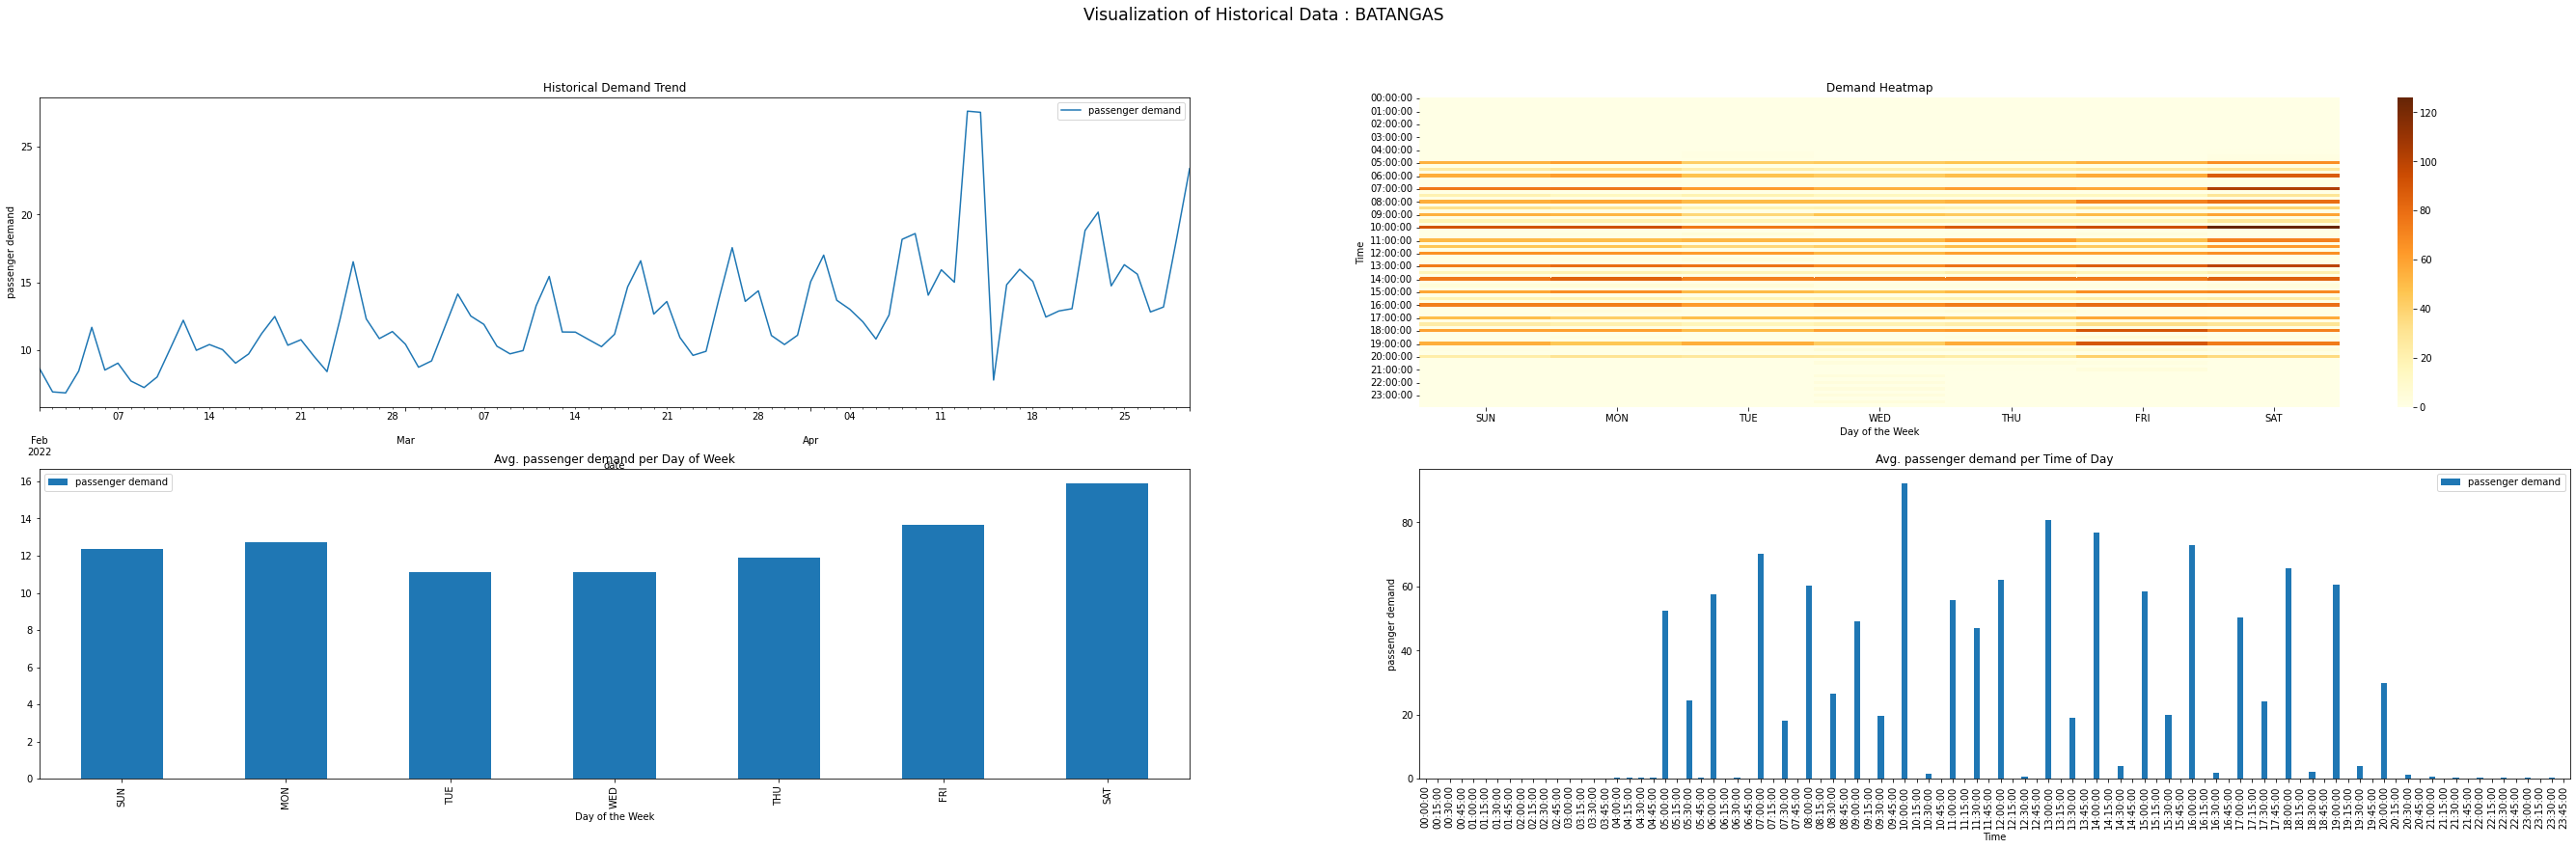

In [ ]:
#@title **Enter Route Number**  {display-mode: "form"}

#@markdown Type your selected option number here. Press the *play* button to run the historical demand summary.
option_number =  7#@param {type:"integer"}
cannot_forecast = False
#@markdown Use data only from Dec 2021 onwards?
start_from_december_2021 = False  #@param {type: "boolean"}

if start_from_december_2021 :
  cleaning_df = cleaning_df[((cleaning_df['date'].dt.month == 12) & (cleaning_df['date'].dt.year == 2021)) + cleaning_df['date'].dt.year >= 2022]
else :
  cleaning_df = cdf_temp

try :
  route = uploaded_routes[option_number]
  to_test = cleaning_df
  to_test = to_test[to_test['route'] == route]
  test_df = pd.DataFrame(to_test.groupby('date').mean()['passenger demand'])
  test_df.fillna(method='ffill', inplace=True)


  puv_type = to_test['line'].unique()[0]




figz
  fig, ax = plt.subplots(2,2)

  test_df.plot(ax=ax[0, 0])
  plt.title(route + " - Historical Demand Trend")

  dow = ['SUN', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT']

  day_demand = pd.DataFrame(to_test.groupby('dayofweek', sort=False).mean()['passenger demand'])
  day_demand = day_demand.reindex(dow)
  day_demand.plot(kind='bar', ax=ax[1,0])

  time_demand = pd.DataFrame(to_test.groupby('time', sort=False).mean()['passenger demand'])
  time_demand.reset_index(inplace=True)
  time_demand['time'] = pd.to_datetime(time_demand['time']).dt.time
  time_demand.set_index('time', inplace=True)
  time_demand.plot(kind='bar', ax=ax[1,1])

  daytime = to_test.groupby(['dayofweek', 'time'], sort=False).mean()['passenger demand']
  dt_heatmap = pd.DataFrame(columns=dow)
  for day in dow :
    for time in time_demand.index :
      dt_heatmap.loc[time, day] = daytime[(day, time)]
  sns.heatmap(dt_heatmap.apply(pd.to_numeric), cmap="YlOrBr", ax=ax[0,1])

  ax[0,0].set_title("Historical Demand Trend")
  ax[0,0].set_ylabel("passenger demand")
  ax[0,0].legend()

  ax[0,1].set_title("Demand Heatmap")
  ax[0,1].set_ylabel("Time")
  ax[0,1].set_xlabel("Day of the Week")

  ax[1,1].set_title("Avg. passenger demand per Time of Day")
  ax[1,1].set_ylabel("passenger demand")
  ax[1,1].set_xlabel("Time")

  ax[1,0].set_title("Avg. passenger demand per Day of Week")
  ax[1,0].set_xlabel("Day of the Week")

  import math
  fig.suptitle("Visualization of Historical Data : " + route, fontsize='xx-large')

  print("===============================================================================")
  print(f"                               SUMMARY:  {route}                              ")
  print("===============================================================================")
  print("                                                                               ")
  print("                                                                               ")
  print(f"Peak day of the week : {day_demand[day_demand['passenger demand'] == day_demand['passenger demand'].max()].index[0]}, with {math.ceil(day_demand['passenger demand'].max())} passengers by average.")
  print(f"Peak time of the day : {time_demand[time_demand['passenger demand'] == time_demand['passenger demand'].max()].index[0]}, with {math.ceil(time_demand['passenger demand'].max())} passengers by average.")
  print(f"Peak day-time combination is : {daytime[daytime.values == daytime.max()].index[0][0]} at {str(daytime[daytime.values == daytime.max()].index[0][1].time())}, with {math.ceil(daytime.max())} passengers by average.")
  print("                                                                               ")
  print("                                                                               ")

  historical = to_test.groupby(['dayofweek', 'time'], sort=False)
  historical_max = historical.max()
  historical_max = historical_max[historical_max['passenger demand'] == historical_max['passenger demand'].max()].index
  print(f"Highest Passenger Volume  : {math.ceil(historical.max().max()['passenger demand'])} on {str(historical.max().max()['date'].date())} ({historical_max[0][0]}, {str(historical_max[0][1].time())})          ")
  print("                                                                               ")
  print("                                                                               ")
except IndexError :
  print("ERROR: Route has no data before Dec 2021")
  cannot_forecast = True

### **Run Forecast**
____________________


Pressing the play button below would yield the following:
- *Graphical Forecast*, showing full historical trend, plus the number of days set;
- *A Tabular Form*, of the forecast average demand per day, containing the following elements.
   - `FORECAST` - The forecasted average number of passengers for the forecast days provided
   - `UPPER BOUND, LOWER BOUND` - possible maximum and minimum values. Provides a range to look at.
   - `MIN (PUV) NEEDED` - minimum PUV needed based on vehicle capacity (*22-25 For Jeeps, 45-60 for Buses*).   

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (365) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=564.152, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=747.435, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=576.391, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=664.192, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=578.751, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=549.084, Time=0.27 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=633.604, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=550.962, Time=0.34 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=550.751, Time=0.27 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=617.530, Time=0.19 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=552.480, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=549.570, Time=0.44 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 2.482 seconds
                     FORECAST for BATANGAS (Provincial): 15 days at 80% CAPACITY                    

,FORECAST DAY #,FORECAST PAX,UPPER BOUND,LOWER BOUND,MIN PUV NEEDED
2022-04-30,1,21.0,30.0,11.0,1.0
2022-05-01,2,19.0,30.0,8.0,1.0
2022-05-02,3,19.0,30.0,7.0,1.0
2022-05-03,4,19.0,30.0,7.0,1.0
2022-05-04,5,19.0,30.0,7.0,1.0
2022-05-05,6,19.0,30.0,7.0,1.0
2022-05-06,7,19.0,30.0,7.0,1.0
2022-05-07,8,19.0,30.0,7.0,1.0
2022-05-08,9,19.0,30.0,7.0,1.0
2022-05-09,10,19.0,30.0,7.0,1.0


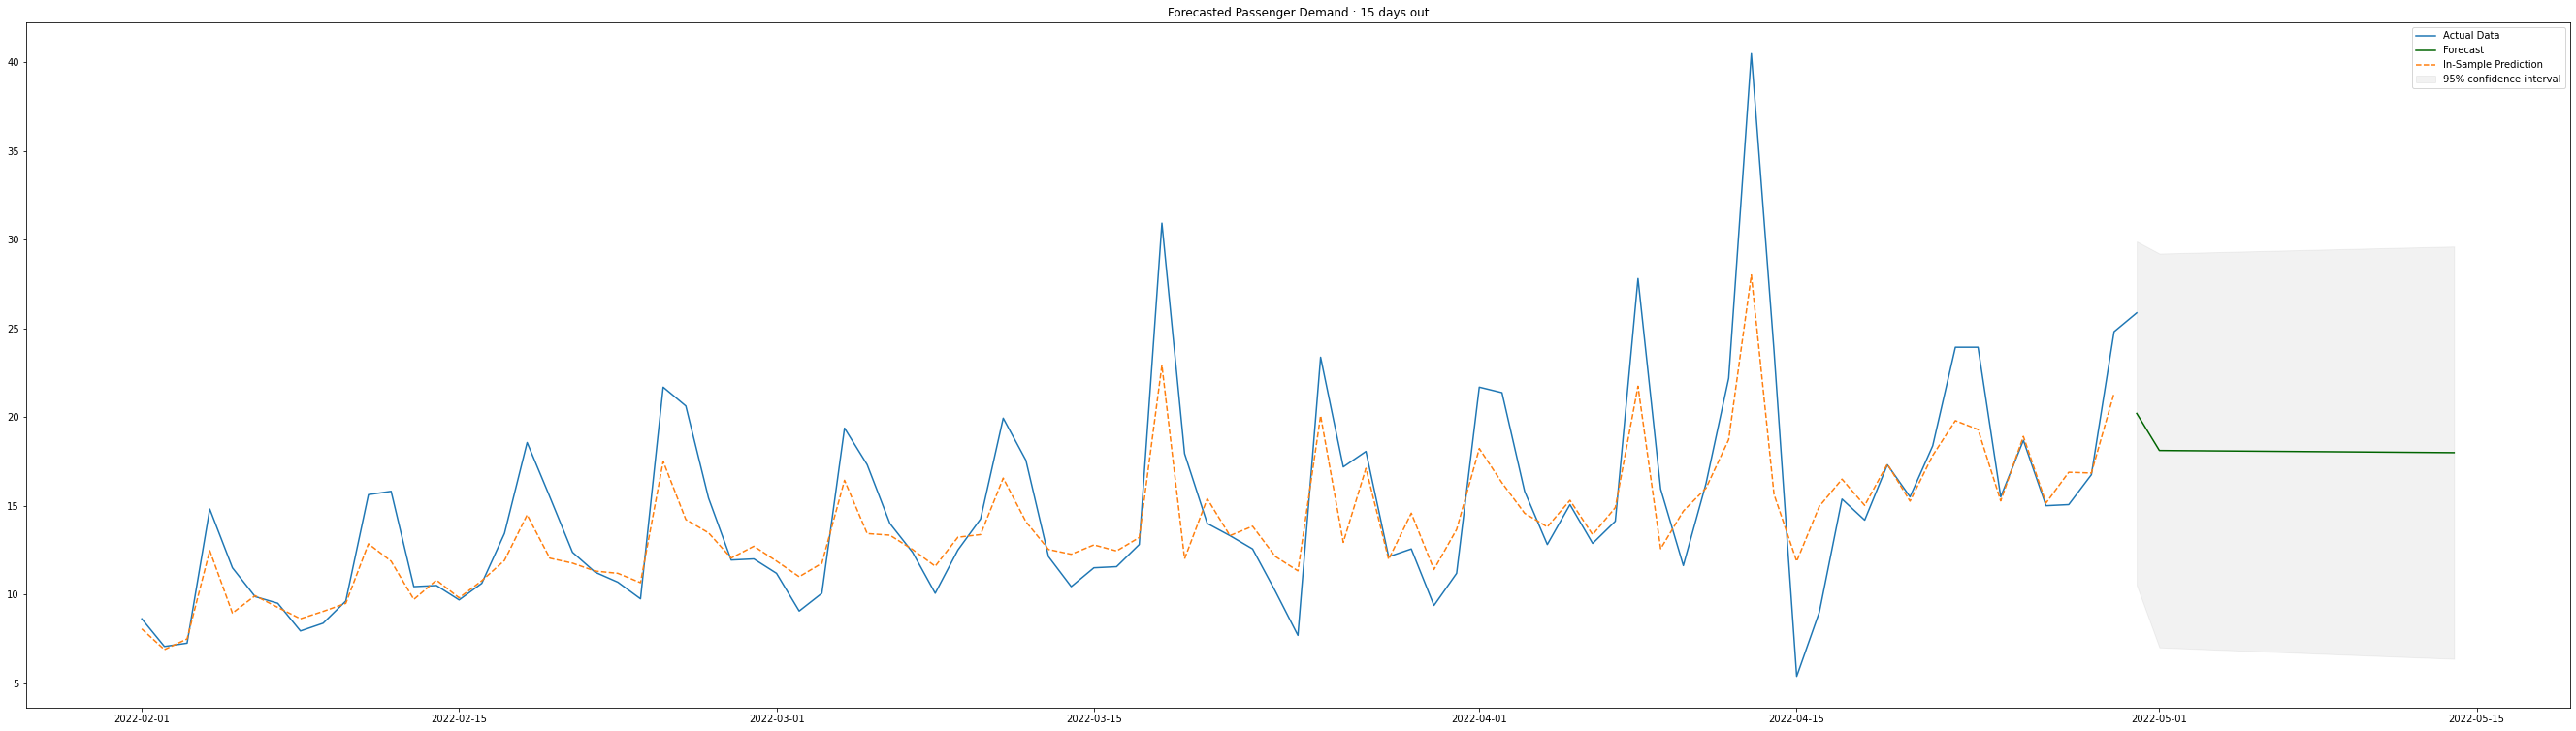

In [ ]:
#@title **Define Parameters** {display-mode: "form", run : "auto"}
#@markdown **How many days would you like to forecast?**


if cannot_forecast :
  print("Unable to forecast due to the error above.")
else :
  days = 15#@param {type : 'integer'}
  #@markdown **CQ capacity**
  cq = "80%" #@param ["50%", "80%", "100%"]

  from pylab import rcParams
  rcParams['figure.figsize'] = 47,13

  #@markdown **Define specific hours?**
  specific_hours = True #@param {type : 'boolean'}


  hr_start = '17:00' #@param  [ '00:00',  '01:00',  '02:00',  '03:00',  '04:00',  '05:00',  '06:00',  '07:00',  '08:00',  '09:00',  '10:00',  '11:00',  '12:00',  '13:00',  '14:00',  '15:00',  '16:00',  '17:00',  '18:00',  '19:00',  '20:00',  '21:00',  '22:00',  '23:00']
  hr_end = '20:00' #@param  [ '00:00',  '01:00',  '02:00',  '03:00',  '04:00',  '05:00',  '06:00',  '07:00',  '08:00',  '09:00',  '10:00',  '11:00',  '12:00',  '13:00',  '14:00',  '15:00',  '16:00',  '17:00',  '18:00',  '19:00',  '20:00',  '21:00',  '22:00',  '23:00']

  def test_stationarity(timeseries):
    from statsmodels.tsa.stattools import adfuller

    print('Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC') #values you want from the value ni demand

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value','# lags used', 'Number of observations used'])
    for key, value in dftest[4].items():
      dfoutput['Critical Values (%s)' %key] = value

    print(dfoutput)


  def AutoArima(df) :
    automodel = pm.auto_arima(df, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=10, max_q=10, # maximum p and q
                          m=365,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          start_P=0,
                          D=0,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)
    return automodel



  import math

  def ForecastPax(df, days, model_fit, cq=cq, puv_type=puv_type) :

    predicted,conf_int = model_fit.predict(n_periods=days, return_conf_int=True)
    index_of_predicted = pd.date_range(df.index[-1], periods = days, freq='D')

    results = pd.DataFrame(columns = ['FORECAST PAX', 'UPPER BOUND', 'LOWER BOUND'])
    # make series for plotting purpose

    if puv_type == 'Provincial' :
      vehicles_needed = 53
    elif puv_type == 'City' :
      vehicles_needed = 24
    else :
      print("Invalid PUV Type")

    cq_factor = {"50%" : 0.5, "80%" : 0.8, "100%" : 1}

    def NonZeroRound(num) :
      try :
        if round(num) == 0 :
          return 1
        else :
          return round(num)
      except ValueError :
        return 1
    day_labeler = pd.Series(range(1,days+1), index=index_of_predicted)
    results['FORECAST PAX'] = predicted_series = pd.Series(predicted, index=index_of_predicted)
    results['LOWER BOUND'] = lower_series = pd.Series(conf_int[:, 0], index=index_of_predicted)
    results['UPPER BOUND'] = upper_series = pd.Series(conf_int[:, 1], index=index_of_predicted)

    results[f'MIN PUV NEEDED'] = results['FORECAST PAX']/(vehicles_needed*cq_factor[cq])
    results[f'MIN PUV NEEDED'] = results[f'MIN PUV NEEDED']
    #results = results.apply(lambda x: round(x, 2))
    results = results.apply(np.ceil)
    results.index.name = 'date'
    results.reset_index(inplace=True)
    results['date'] = results['date'].dt.date
    results.set_index('date', inplace=True)
    # Plot
    plt.plot(df, label='Actual Data')
    plt.plot(predicted_series, color='darkgreen', label='Forecast')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.05,
                    label = '95% confidence interval')
    plt.plot(pd.Series(model_fit.predict_in_sample()[1:], index=df.index[:-1]), label='In-Sample Prediction', linestyle='--')
    plt.legend()
    plt.title(f'Forecasted Passenger Demand : {days} days out')

    print("===================================================================================================================")
    print(f"                     FORECAST for {route} ({puv_type}): {days} days at {cq} CAPACITY                               ")
    print("===================================================================================================================")
    print("                                                                                                              ")
    print("                                                                                                              ")
    display(data_table.DataTable(day_labeler.rename('FORECAST DAY #').to_frame().join(results), include_index=False, num_rows_per_page=50))

  if specific_hours :
    to_test = cleaning_df
    to_test = to_test[to_test['route'] == route]
    peak_df = pd.DataFrame(to_test[(to_test['time'].dt.hour >= int(hr_start[:2])) & (to_test['time'].dt.hour <= int(hr_end[:2]))].groupby('date').mean()['passenger demand'])
    model_fit = AutoArima(peak_df)
    ForecastPax(peak_df, days, model_fit=model_fit)
  else :
    model_fit = AutoArima(test_df)
    ForecastPax(test_df, days, model_fit=model_fit)